In [1]:
pip install pandas_datareader

Note: you may need to restart the kernel to use updated packages.


In [2]:
### Data Collection

import pandas_datareader as pdr

In [3]:
df = pdr.get_data_tiingo('AAPL',api_key='1a686b489754acf32d9c285a7ad8be10f717c3d3')

C:\Users\khair\anaconda3\lib\site-packages\pandas_datareader\tiingo.py:234: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  return pd.concat(dfs, self._concat_axis)


In [4]:
df.to_csv('AAPL.csv')

In [5]:
import pandas as pd

In [6]:
df = pd.read_csv('AAPL.csv')

In [7]:
df.head()

,symbol,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
0,AAPL,2018-04-10 00:00:00+00:00,173.25,174.00,171.53,173.00,28614241,41.234815,41.413321,40.825442,41.175314,114456964,0.0,1.0
1,AAPL,2018-04-11 00:00:00+00:00,172.44,173.92,171.70,172.23,22431640,41.042029,41.394281,40.865904,40.992048,89726560,0.0,1.0
2,AAPL,2018-04-12 00:00:00+00:00,174.14,175.00,173.04,173.41,22889285,41.446642,41.651329,41.184834,41.272897,91557140,0.0,1.0
3,AAPL,2018-04-13 00:00:00+00:00,174.73,175.84,173.85,174.78,25124255,41.587067,41.851255,41.377620,41.598967,100497020,0.0,1.0
4,AAPL,2018-04-16 00:00:00+00:00,175.82,176.19,174.83,175.03,21578420,41.846495,41.934558,41.610867,41.658469,86313680,0.0,1.0


In [8]:
df2 = df.reset_index()['close']

In [9]:
df2.head()

0    173.25
1    172.44
2    174.14
3    174.73
4    175.82
Name: close, dtype: float64

In [10]:
df2[1228:]

1228    146.71
1229    147.92
1230    147.41
1231    145.31
1232    145.91
1233    151.03
1234    153.83
1235    151.60
1236    152.87
1237    150.59
1238    148.50
1239    150.47
1240    152.59
1241    152.99
1242    155.85
1243    155.00
1244    157.40
1245    159.28
1246    157.83
1247    158.93
1248    160.25
1249    158.28
1250    157.65
1251    160.77
1252    162.36
1253    164.90
1254    166.17
1255    165.63
1256    163.76
1257    164.66
Name: close, dtype: float64

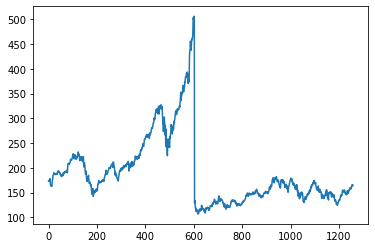

In [11]:
import matplotlib.pyplot as plt
plt.plot(df2)

In [12]:
df2.shape

(1258,)

In [13]:
### LSTM are sensitive to the scale of the data. So we apply MinMax Scaler where values are between 0 to 1

In [14]:
import numpy as np

In [15]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
df2 = scaler.fit_transform(np.array(df2).reshape(-1,1))

In [16]:
df2

array([[0.16633688],
       [0.16430808],
       [0.16856606],
       ...,
       [0.1472511 ],
       [0.14256731],
       [0.14482154]])

In [17]:
# Splitting dataset  
training_size = int(len(df2)*0.65)
test_size = len(df2) - training_size
train_data, test_data = df2[0:training_size,:],df2[training_size:len(df2),:1]

In [18]:
import numpy 
## Convert an array of values into a dataset matrix

def create_dataset(dataset,time_step = 1):
    dataX,dataY = [],[]
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step),0]
        dataX.append(a)
        dataY.append(dataset[i+time_step,0])
    return numpy.array(dataX),numpy.array(dataY)
        


In [19]:
# reshape into X = t, t+1, t+2 and Y = t+3
time_step = 100
X_train,Y_train = create_dataset(train_data,time_step)
X_test, Y_test = create_dataset(test_data,time_step)

In [20]:
X_train.shape

(716, 100)

In [21]:
Y_train.shape

(716,)

In [22]:
X_test.shape

(340, 100)

In [23]:
Y_test.shape

(340,)

In [24]:
# reshape input to be [sample,time_step,features] which is required for LSTM

X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1],1)


# Create LSTM Model

In [25]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [26]:
model = Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])

In [27]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 50)           10400     
                                                                 
 lstm_1 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [28]:
model.fit(X_train,Y_train,validation_data=(X_test,Y_test),epochs=5,batch_size=64)

Epoch 1/5
12/12 [==============================] - 5s 165ms/step - loss: 0.0412 - accuracy: 0.0014 - val_loss: 0.0017 - val_accuracy: 0.0000e+00
Epoch 2/5
12/12 [==============================] - 1s 91ms/step - loss: 0.0131 - accuracy: 0.0028 - val_loss: 0.0026 - val_accuracy: 0.0000e+00
Epoch 3/5
12/12 [==============================] - 1s 92ms/step - loss: 0.0103 - accuracy: 0.0028 - val_loss: 4.7815e-04 - val_accuracy: 0.0000e+00
Epoch 4/5
12/12 [==============================] - 1s 96ms/step - loss: 0.0095 - accuracy: 0.0028 - val_loss: 4.9811e-04 - val_accuracy: 0.0000e+00
Epoch 5/5
12/12 [==============================] - 1s 95ms/step - loss: 0.0082 - accuracy: 0.0028 - val_loss: 4.3552e-04 - val_accuracy: 0.0000e+00


In [29]:
### Lets Do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

11/11 [==============================] - 0s 18ms/step


In [30]:
##Transformback to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [31]:
### Calculate RMSE performance metrics
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(Y_train,train_predict))

220.56425050114473

In [32]:
### Test Data RMSE
math.sqrt(mean_squared_error(Y_test,test_predict))

158.6508290680763

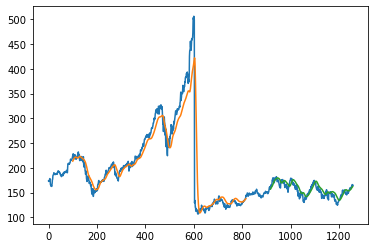

In [33]:
### Plotting 
# shift train predictions for plotting
look_back=100
trainPredictPlot = numpy.empty_like(df2)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(df2)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df2)-1, :] = test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df2))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [34]:
len(test_data)

441

In [35]:
x_input=test_data[341:].reshape(1,-1)
x_input.shape

(1, 100)

In [36]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

In [37]:
temp_input

[0.10735128365685653,
 0.103794614902943,
 0.10820288040075132,
 0.10507201001878513,
 0.10990607388854096,
 0.11133375078271751,
 0.10311834690043825,
 0.10855353788353161,
 0.11078271759549146,
 0.10336881653099561,
 0.09362554790231681,
 0.08598622417031926,
 0.10316844082654975,
 0.10386975579211016,
 0.1026174076393237,
 0.0996618659987476,
 0.09034439574201625,
 0.08541014402003755,
 0.08969317470256727,
 0.08846587351283652,
 0.0943018159048215,
 0.096756418284283,
 0.09109580463368816,
 0.07428929242329363,
 0.06930494677520344,
 0.06394489668127734,
 0.06376956793988725,
 0.07165936130244199,
 0.0635942391984971,
 0.06266750156543521,
 0.05808390732623664,
 0.04809016906700059,
 0.05703193487789604,
 0.05783343769567939,
 0.04566061365059482,
 0.04889167188478394,
 0.045535378835316165,
 0.05705698184095176,
 0.05838447088290544,
 0.05983719474013771,
 0.06675015654351907,
 0.0665497808390732,
 0.0699311208515967,
 0.0728866624921728,
 0.07105823418910456,
 0.07120851596743893

In [38]:
# demonstrate prediction for next 10 days
from numpy import array

lst_output=[]
n_steps=100
i=0
while(i<30):
    
    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)

[0.14188156]
101
1 day input [0.10379461 0.10820288 0.10507201 0.10990607 0.11133375 0.10311835
 0.10855354 0.11078272 0.10336882 0.09362555 0.08598622 0.10316844
 0.10386976 0.10261741 0.09966187 0.0903444  0.08541014 0.08969317
 0.08846587 0.09430182 0.09675642 0.0910958  0.07428929 0.06930495
 0.0639449  0.06376957 0.07165936 0.06359424 0.0626675  0.05808391
 0.04809017 0.05703193 0.05783344 0.04566061 0.04889167 0.04553538
 0.05705698 0.05838447 0.05983719 0.06675016 0.06654978 0.06993112
 0.07288666 0.07105823 0.07120852 0.07772073 0.08583594 0.08939261
 0.08771446 0.09297433 0.09790858 0.09056982 0.09380088 0.09665623
 0.11015654 0.11937383 0.11243582 0.11974953 0.11291171 0.11028178
 0.11063244 0.11774577 0.11611772 0.12145272 0.11739512 0.11448967
 0.10429555 0.10537257 0.10659987 0.09986224 0.10289292 0.10161553
 0.09635567 0.09785848 0.11068253 0.11769568 0.11211021 0.11529117
 0.10958046 0.10434565 0.1092799  0.11458986 0.11559173 0.12275517
 0.12062617 0.12663745 0.13134627

In [39]:
day_new=np.arange(1,101)
day_pred=np.arange(101,131)

In [40]:
import matplotlib.pyplot as plt

In [41]:
len(df2)

1258

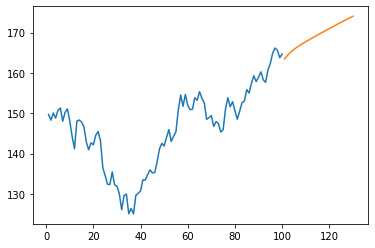

In [42]:
plt.plot(day_new,scaler.inverse_transform(df2[1158:]))
plt.plot(day_pred,scaler.inverse_transform(lst_output))

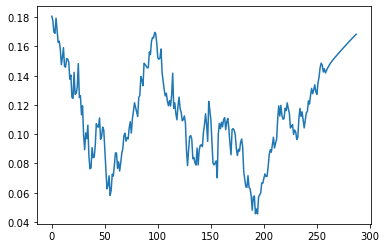

In [46]:
df3=df2.tolist()
df3.extend(lst_output)
plt.plot(df3[1000:])

In [44]:
df3=scaler.inverse_transform(df3).tolist()

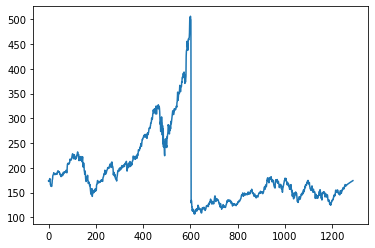

In [45]:
plt.plot(df3)